# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install lightgbm
!pip install catboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from scipy import stats as st

from numpy.random import RandomState

In [2]:
data = pd.read_csv('C:/datasets/11/autos.csv')

data.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# Удаляю бесполезные для предсказания цены данные

data = data.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'])

In [6]:
# В столбце с информацией о ремонте автомобилей меняю yes и no на 1 и 0.

data['Repaired'] = data['Repaired'].map({'yes':1, 'no':0})

<AxesSubplot:>

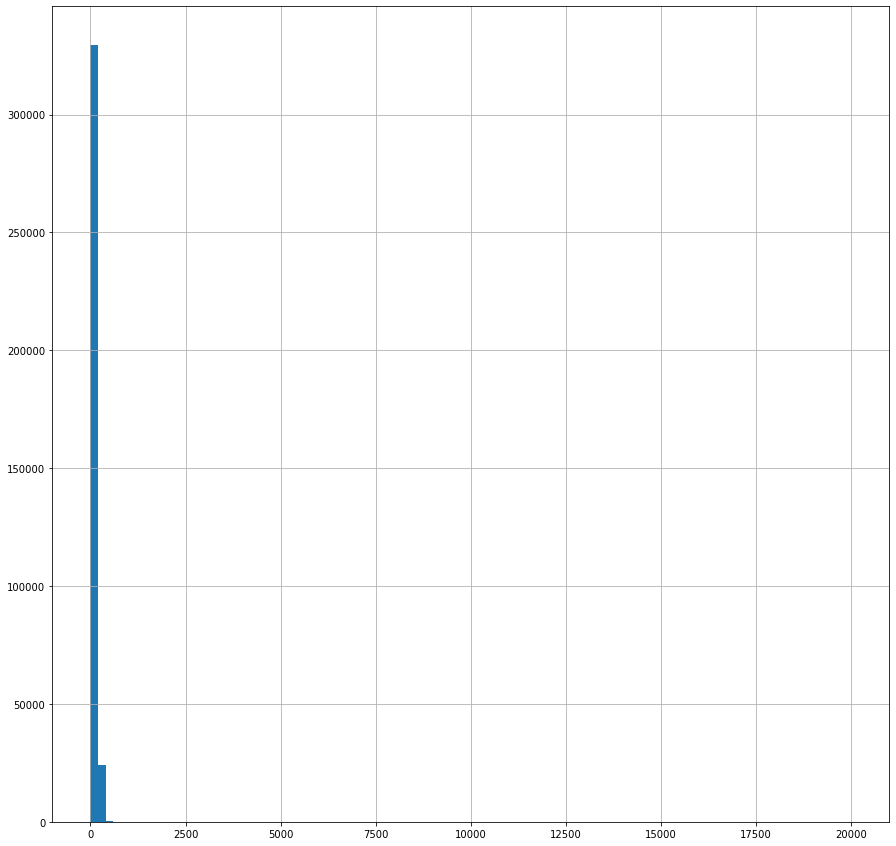

In [7]:
data['Power'].hist(figsize=(15,15), bins=100)

In [8]:
# Задаю минимальную и максимальную мощность автомобилей от 20 до 2030 л.с.

data = data.query('Power > 20 & Power <= 2030')

In [9]:
data['Price'].describe()

count    313598.000000
mean       4705.183608
std        4591.435961
min           0.000000
25%        1250.000000
50%        2999.000000
75%        6890.000000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:>

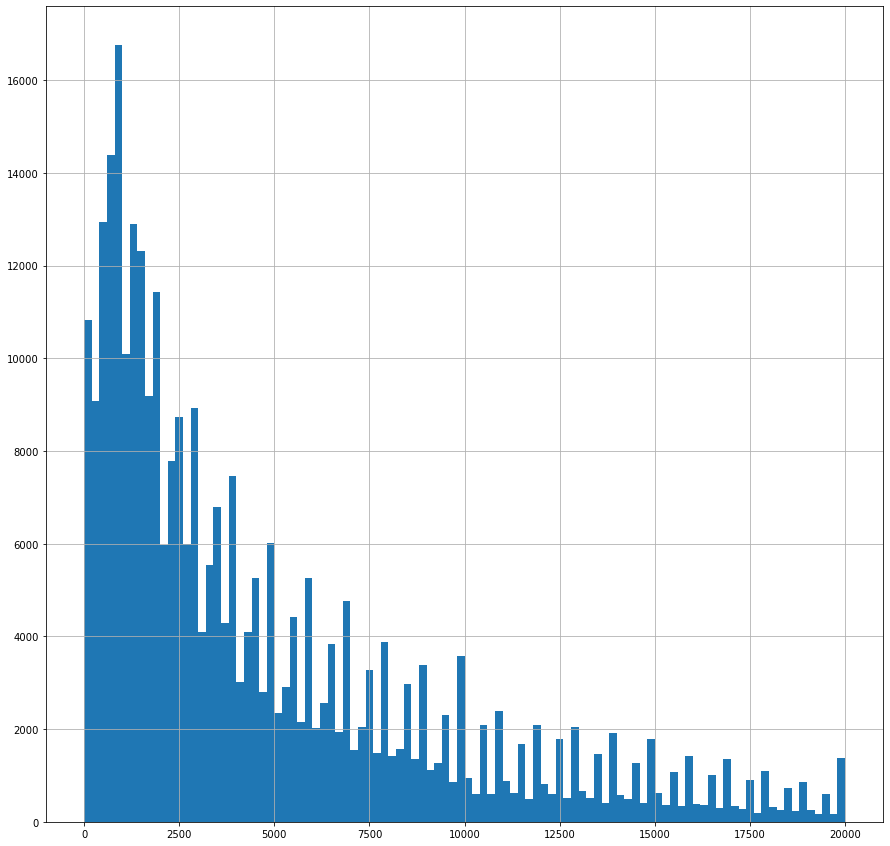

In [10]:
# Отсеиваю все автомобили, цена которых ниже 100.

data['Price'].hist(figsize=(15,15), bins=100)

In [11]:
data = data.query('Price >= 100')

<AxesSubplot:>

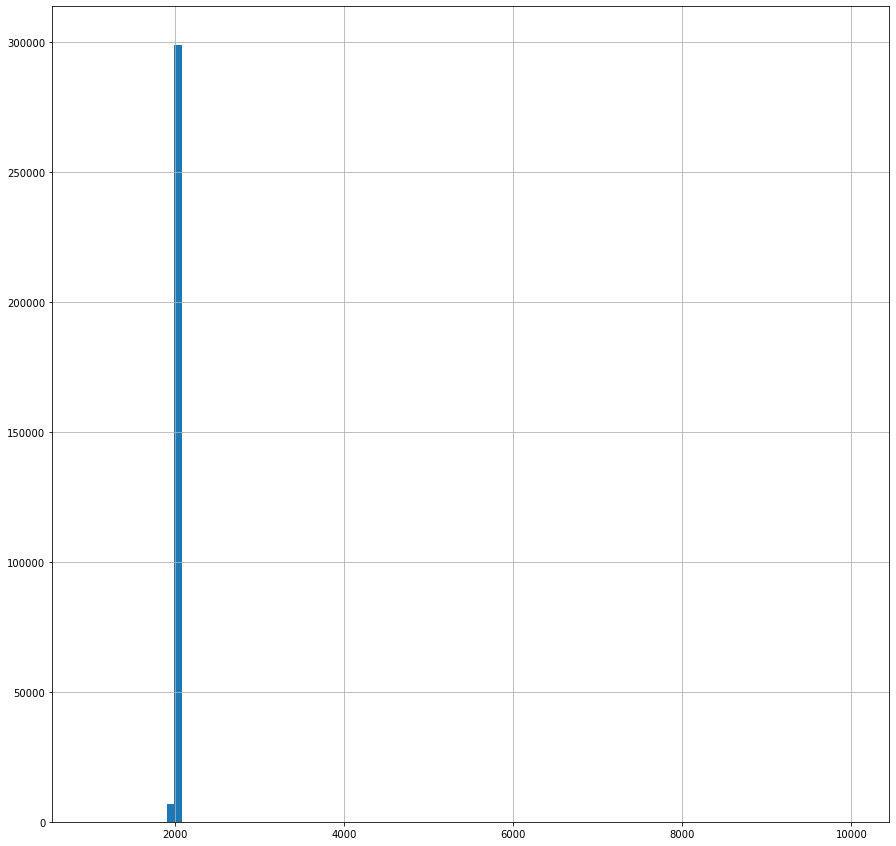

In [12]:
data['RegistrationYear'].hist(figsize=(15,15), bins=100)

In [13]:
# Задаю начальный и конечный год регистрации автомобиля с 1900 до 2016

data = data.query('RegistrationYear > 1900 & RegistrationYear <= 2016')

In [14]:
# Неясно, как адекватно заполнить оставшиеся пропуски, поэтому я заполняю их значением 'unknown'

data = data.fillna('unknown')

# Удаляю дубликаты
data = data.drop_duplicates()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256215 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             256215 non-null  int64 
 1   VehicleType       256215 non-null  object
 2   RegistrationYear  256215 non-null  int64 
 3   Gearbox           256215 non-null  object
 4   Power             256215 non-null  int64 
 5   Model             256215 non-null  object
 6   Kilometer         256215 non-null  int64 
 7   FuelType          256215 non-null  object
 8   Brand             256215 non-null  object
 9   Repaired          256215 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.5+ MB


In [16]:
#КОД РЕВЬЮЕРА

data.describe()

,Price,RegistrationYear,Power,Kilometer
count,256215.000000,256215.000000,256215.000000,256215.000000
mean,4961.181082,2002.891451,122.746779,127306.344281
std,4662.834854,6.661306,65.609525,37332.884077
min,100.000000,1910.000000,21.000000,5000.000000
25%,1399.000000,1999.000000,80.000000,125000.000000
50%,3300.000000,2003.000000,114.000000,150000.000000
75%,7150.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,2018.000000,150000.000000


In [17]:
# кодирую категориальные признаки с помощью техники прямого коодирования One-Hot Encoding

data_ohe = pd.get_dummies(data, drop_first=True)

In [18]:
# Масштабирую количественные данные в обучающей и тестовой выборках

target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

numeric = ['Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<b>Итоги подготовки данных:</b>

- Были удалены бесполезные для предсказания цены данные ('DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen').
- В столбце с информацией о ремонте автомобилей ('Repaired') изменено yes и no на 1 и 0.
- Задана достоверная минимальная и максимальная мощность автомобилей от 20 до 2030 л.с.
- Заданы достоверные начальный и конечный год регистрации автомобиля с 1900 до 2023.
- Оставшиеся после обработки даннных пропуски заполнены значением 'unknown'.
- Удалены дубликаты.
- Была использована техника прямого коодирования One-Hot Encoding для кодирования категориальных признаков.
- Количественные данные в обучающей и тестовой выборках промасштабированы методом стандартизации.

## Обучение моделей

In [19]:
# Создаю скорер метрики RMSE для подбора параметров

def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict, squared=False)
    return RMSE

scorer = make_scorer(RMSE, greater_is_better=False)

In [20]:
# Задаю параметры кросс-валидации для подбора параметров

cross_val = ShuffleSplit(n_splits=5, test_size=0.25, random_state=12345)

In [21]:
categories  = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

## LGBMRegressor

In [22]:
# Провожу подбор параметров для LGBM модели методом кросс-валидации

LGBM_model = LGBMRegressor(random_state=12345)

parameters_grid_1 = {'max_depth': [2, 6, 10],
                   'learning_rate': [0.01, 0.1],
                   'n_estimators': [25, 50, 100, 200]}

LGBM_grid_cross_val = GridSearchCV(LGBM_model, parameters_grid_1, scoring=scorer, cv=cross_val)

In [23]:
LGBM_grid_cross_val.fit(features_train, target_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.25, train_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 6, 10],
                         'n_estimators': [25, 50, 100, 200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [24]:
print(LGBM_grid_cross_val.best_score_)

-1646.741911314231


In [25]:
print(LGBM_grid_cross_val.best_params_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [26]:
# Обучаю LGBM модель и вычисляю метрику RMSE

model_LGBM = LGBMRegressor(max_depth=10, n_estimators=200, learning_rate=0.1, random_state=12345)

In [27]:
%%time
model_LGBM.fit(features_train, target_train)

CPU times: total: 8.17 s
Wall time: 851 ms


LGBMRegressor(max_depth=10, n_estimators=200, random_state=12345)

In [28]:
%%time
predictions_LGBM = model_LGBM.predict(features_test)

CPU times: total: 2.52 s
Wall time: 188 ms


## LinearRegression

In [41]:
# Провожу подбор параметров для линейной регрессии методом кросс-валидации

model_LinearRegression = LinearRegression()

model_LinearRegression_cross_val = cross_val_score(
    model_LinearRegression, 
    features_train, 
    target_train, 
    scoring=scorer, 
    cv=cross_val
)

print(model_LinearRegression_cross_val.max())

-2728.433389338405


In [30]:
%%time
model_LinearRegression.fit(features_train, target_train)

CPU times: total: 13.6 s
Wall time: 2.02 s


LinearRegression()

In [31]:
%%time
predictions_LinearRegression = model_LinearRegression.predict(features_test)

CPU times: total: 609 ms
Wall time: 71.8 ms


##  CatBoostRegressor

In [32]:
# Провожу подбор параметров для CatBoost модели методом кросс-валидации

CatBoost_model = CatBoostRegressor(random_state=12345)

parameters_grid_2 = {'max_depth': [2, 6, 10],
                   'learning_rate': [0.01, 0.1],
                   'l2_leaf_reg': [1, 3, 5, 7, 9],
                   'iterations': [50, 100, 150, 200]}

CatBoost_grid_cross_val = GridSearchCV(CatBoost_model, parameters_grid_2, scoring=scorer, cv=cross_val)

In [33]:
CatBoost_grid_search = CatBoost_model.grid_search(parameters_grid_2, 
                                                X=features_train, 
                                                y=target_train, 
                                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6758.3512903	test: 6748.7035218	best: 6748.7035218 (0)	total: 160ms	remaining: 7.86s
1:	learn: 6707.4448687	test: 6697.7681028	best: 6697.7681028 (1)	total: 165ms	remaining: 3.96s
2:	learn: 6656.6361311	test: 6646.9879875	best: 6646.9879875 (2)	total: 170ms	remaining: 2.65s
3:	learn: 6606.5131892	test: 6596.7622354	best: 6596.7622354 (3)	total: 174ms	remaining: 2s
4:	learn: 6556.8717473	test: 6547.0463974	best: 6547.0463974 (4)	total: 178ms	remaining: 1.6s
5:	learn: 6507.8990518	test: 6498.0975911	best: 6498.0975911 (5)	total: 183ms	remaining: 1.34s
6:	learn: 6460.3478677	test: 6450.4365162	best: 6450.4365162 (6)	total: 188ms	remaining: 1.15s
7:	learn: 6412.8523437	test: 6402.9411688	best: 6402.9411688 (7)	total: 192ms	remaining: 1.01s
8:	learn: 6365.6881200	test: 6355.8305063	best: 6355.8305063 (8)	total: 197ms	remaining: 898ms
9:	learn: 6319.4976426	test: 6309.6238012	best: 6309.6238012 (9)	total: 202ms	remaining: 808ms
10:	learn: 6273.3727713	test: 6263.4024225	best: 6263.

In [34]:
CatBoost_model.get_params()

{'loss_function': 'RMSE',
 'random_state': 12345,
 'depth': 10,
 'l2_leaf_reg': 1,
 'iterations': 200,
 'learning_rate': 0.1}

In [35]:
CatBoost_model.get_best_score()

{'learn': {'RMSE': 1579.2766579432232}}

In [36]:
# Обучаю CatBoost модель и вычисляю метрику RMSE

model_CatBoost = CatBoostRegressor(max_depth=10, iterations=200, learning_rate=0.1, l2_leaf_reg=1, random_state=12345)

In [37]:
%%time
model_CatBoost.fit(features_train, target_train)

0:	learn: 4331.6479145	total: 26.6ms	remaining: 5.29s
1:	learn: 4037.2588465	total: 59.1ms	remaining: 5.85s
2:	learn: 3774.0352507	total: 90.5ms	remaining: 5.94s
3:	learn: 3545.7043493	total: 116ms	remaining: 5.67s
4:	learn: 3343.4607768	total: 137ms	remaining: 5.34s
5:	learn: 3165.1492836	total: 160ms	remaining: 5.19s
6:	learn: 3009.9813919	total: 184ms	remaining: 5.07s
7:	learn: 2872.6829197	total: 205ms	remaining: 4.92s
8:	learn: 2752.1352806	total: 227ms	remaining: 4.82s
9:	learn: 2650.0740890	total: 250ms	remaining: 4.74s
10:	learn: 2555.8853825	total: 273ms	remaining: 4.69s
11:	learn: 2474.1803872	total: 294ms	remaining: 4.6s
12:	learn: 2405.0019174	total: 316ms	remaining: 4.54s
13:	learn: 2340.2245596	total: 337ms	remaining: 4.48s
14:	learn: 2281.9137156	total: 358ms	remaining: 4.42s
15:	learn: 2229.4703797	total: 382ms	remaining: 4.39s
16:	learn: 2185.7683425	total: 403ms	remaining: 4.34s
17:	learn: 2147.5933585	total: 424ms	remaining: 4.29s
18:	learn: 2114.6749047	total: 446ms

In [38]:
%%time
predictions_CatBoost = model_CatBoost.predict(features_test)

CPU times: total: 266 ms
Wall time: 41.5 ms


<b>Итоги обучения моделей:</b>

Качество моделей на кросс-валидации:
- RMSE LGBM модели: <b>1646.741911314231</b>
- RMSE случайного линейной регрессии: <b>2728.433389338405</b>
- RMSE CatBoost модели: <b>1579.2766579432232</b>

Скорость моделей (Wall time):
- Время обучения модели LGBM - <b>851 ms</b>. Время предсказания модели LGBM - <b>188 ms</b>.
- Время обучения линейной регрессии - <b>2.02 s</b>. Время предсказания линейной регрессии - <b>71.8 ms</b>.
- Время обучения модели CatBoost - <b>5 s</b>. Время предсказания модели CatBoost - <b>41.5 ms</b>.


In [46]:
results = {'Модель':['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor'], 
        'Скорость обучения':['2.02 s', '5 s', '851 ms'],
        'Скорость предсказания': ['71.8 ms', '41.5 ms', '188 ms'],
        'Качество предсказания': [2728.43, 1579.27, 1646.74]}
results = pd.DataFrame(results)
results

,Модель,Скорость обучения,Скорость предсказания,Качество предсказания
0,LinearRegression,2.02 s,71.8 ms,2728.43
1,CatBoostRegressor,5 s,41.5 ms,1579.27
2,LGBMRegressor,851 ms,188 ms,1646.74


## Анализ моделей

1. На первом месте по качеству - CatBoost модель с показателем метрики RMSE <b>1579.2766579432232</b>.
2. На втором месте по качеству - LGBM модель с показателем метрики RMSE <b>1646.741911314231</b>.
3. На третьем месте по качеству - линейная регрессия с показателем метрики RMSE <b>2728.433389338405</b>.



1. На первом месте по времени обучения LGBM модель: <b>851 ms</b>.
2. На втором месте по времени обучения линейная регрессия: <b>2.02 s</b>.
3. На третьем месте по времени обучения CatBoost модель: <b>5 s</b>.



1. На первом месте по времени предсказания CatBoost модель: <b>41.5 ms</b>.
2. На втором месте по времени предсказания линейная регрессия: <b>71.8 ms</b>.
3. На третьем месте по времени предсказания LGBM модель: <b>188 ms</b>.



Наиболее качественной и быстрой в предсказании является CatBoost модель, однако скорость обучения у неё значиительно ниже. LGBM модель практически не отстает от CatBoost модели по качеству, намного преышает по скорости обучения, однако её скорость предсказания значительно ниже. Линейная регрессия значительно ниже по качеству, и при этом по скорости обучения и предсказания не занимает первых мест.

Таким образом, наиболее оптимальной является модель <b>CatBoostRegressor</b>, и LGBMRegressor - рядом с ней.

## Проверка лучших моделей на тестовой выборке

In [40]:
print('RMSE CatBoost модели на тестовой выборке:', RMSE(target_test, predictions_CatBoost))

RMSE CatBoost модели на тестовой выборке: 1632.798774140559


In [43]:
print('RMSE LGBM модели на тестовой выборке:', RMSE(target_test, predictions_LGBM))

RMSE LGBM модели на тестовой выборке: 1636.9489776272512


- RMSE CatBoost модели на тестовой выборке: 1632.798774140559
- RMSE LGBM модели на тестовой выборке: 1636.948977627251

# Вывод

<b>Итоги подготовки данных:</b>

- Были удалены бесполезные для предсказания цены данные ('DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen').
- В столбце с информацией о ремонте автомобилей ('Repaired') изменено yes и no на 1 и 0.
- Задана достоверная минимальная и максимальная мощность автомобилей от 20 до 2030 л.с.
- Заданы достоверные начальный и конечный год регистрации автомобиля с 1900 до 2016.
- Оставшиеся после обработки даннных пропуски заполнены значением 'unknown'.
- Удалены дубликаты.
- Была использована техника прямого коодирования One-Hot Encoding для кодирования категориальных признаков.
- Количественные данные в обучающей и тестовой выборках промасштабированы методом стандартизации.

<b>Итоги обучения моделей:</b>

Качество моделей на кросс-валидации:
- RMSE LGBM модели: <b>1646.741911314231</b>
- RMSE случайного линейной регрессии: <b>2728.433389338405</b>
- RMSE CatBoost модели: <b>1579.2766579432232</b>

Скорость моделей (Wall time):
- Время обучения модели LGBM - <b>851 ms</b>. Время предсказания модели LGBM - <b>188 ms</b>.
- Время обучения линейной регрессии - <b>2.02 s</b>. Время предсказания линейной регрессии - <b>71.8 ms</b>.
- Время обучения модели CatBoost - <b>5 s</b>. Время предсказания модели CatBoost - <b>41.5 ms</b>.


<b>Анализ моделей:</b>

1. На первом месте по качеству - CatBoost модель с показателем метрики RMSE <b>1579.2766579432232</b>.
2. На втором месте по качеству - LGBM модель с показателем метрики RMSE <b>1646.741911314231</b>.
3. На третьем месте по качеству - линейная регрессия с показателем метрики RMSE <b>2728.433389338405</b>.



1. На первом месте по времени обучения LGBM модель: <b>851 ms</b>.
2. На втором месте по времени обучения линейная регрессия: <b>2.02 s</b>.
3. На третьем месте по времени обучения CatBoost модель: <b>5 s</b>.



1. На первом месте по времени предсказания CatBoost модель: <b>41.5 ms</b>.
2. На втором месте по времени предсказания линейная регрессия: <b>71.8 ms</b>.
3. На третьем месте по времени предсказания LGBM модель: <b>188 ms</b>.



Наиболее качественной и быстрой в предсказании является CatBoost модель, однако скорость обучения у неё значиительно ниже. LGBM модель практически не отстает от CatBoost модели по качеству, намного преышает по скорости обучения, однако её скорость предсказания значительно ниже. Линейная регрессия значительно ниже по качеству, и при этом по скорости обучения и предсказания не занимает первых мест.

Таким образом, наиболее оптимальной является модель <b>CatBoostRegressor</b>, и LGBMRegressor - рядом с ней.

- RMSE CatBoost модели на тестовой выборке: 1632.798774140559
- RMSE LGBM модели на тестовой выборке: 1636.948977627251